In [49]:
import numpy as np
import numpy.random as np_rand
import scipy.special as sc
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from scipy.io import arff
from numpy.lib.recfunctions import structured_to_unstructured
from timeit import default_timer

from dp import *

In [50]:
# Define parameters
k = 20 # truncation level for truncated drichlet process
alpha = 5 # concentration parameter for DP
n_samples = 100 # Number of X sample points to generate
num_of_gaussian_dim = 2 # Number of dimensions in Gaussian distribution from which X will be sampled
rho = 0.8 # first-order autocorrelation coefficient for covariance matrix of Gaussian distribution from which X will be sampled
variance_prior = 100 # variance of Gaussian baseline distribution in DP
variance_sample = 4 # variance of the gaussion from which X will be sampled


In [51]:
# Generate the baseline 2-dim Gaussion distribution prior of DP
base_mean = np.zeros(num_of_gaussian_dim) # zero-mean Gaussian
base_cov = np.eye(num_of_gaussian_dim) * variance_prior # scaled for comparison across dimensions (values should be of similar order)

#base_cov = [[100, 0], [0, 100]]
print("base_mean: \n", base_mean)
print("base_cov: \n", base_cov)

base_mean: 
 [0. 0.]
base_cov: 
 [[100.   0.]
 [  0. 100.]]


In [52]:
# Generate eta from baseline distribution of DP (Unique values of means(each per dim) from the 2-dim gaussion prior distribution of DP)
eta_params = np_rand.multivariate_normal(base_mean, base_cov, size=k)
#means = norm.rvs(base_mean, base_cov) # draw normal random variables for means
print("eta_params:\n", eta_params)

eta_params:
 [[ -1.33968354 -20.39941181]
 [-10.92027952 -20.46482418]
 [ -0.85638892   0.8906289 ]
 [ -8.30207129  17.205527  ]
 [-14.4366115   -2.03278043]
 [ -1.1127506  -24.83086575]
 [-14.07890514  -8.73685798]
 [ -2.28978526  -8.81383027]
 [ -6.23682174  -0.76660695]
 [ 17.63098015   3.03477452]
 [ -3.80625242  13.08851192]
 [  4.22704462   5.38242775]
 [ -7.14472709   1.60550852]
 [ 13.12509242  -2.54940056]
 [ 19.56125516  -9.28319993]
 [ -1.35188413 -16.48554435]
 [  9.99986384  -2.41039399]
 [ 16.14207682  -5.26522745]
 [-10.15144824   4.14078195]
 [  7.69000865 -18.29817594]]


In [53]:
# DP using stick-breaking technique
V_params = np_rand.beta(1, alpha, size=k)
V_params[k-2] = 1 #Truncate DP construction at K by setting V_K-1 = 1, but in our case k index start from 0
print("V_params:\n ", V_params)

theta_params = np.zeros(k) # initialize the theta_params
remaining_stick = 1 # initialize the remaining stick length
for i in range(k):
    theta_params[i] = V_params[i] * remaining_stick # break the stick
    remaining_stick *= (1 - V_params[i]) # update the remaining stick length
print("theta_params:\n ", theta_params)

V_params:
  [0.19016858 0.05629973 0.26945925 0.01355687 0.11399253 0.10873956
 0.19577766 0.04888662 0.06532494 0.27136868 0.34067935 0.42882705
 0.23386836 0.34658189 0.61650431 0.1041686  0.30230128 0.07399549
 1.         0.15468028]
theta_params:
  [0.19016858 0.04559329 0.20593103 0.0075689  0.06278004 0.05306035
 0.08514328 0.01709832 0.02173075 0.08437543 0.07718092 0.06405352
 0.01995262 0.02265362 0.0263305  0.00170616 0.00443557 0.0007575
 0.00947962 0.        ]


In [54]:
# Generate the first-order autocorrelation fixed covariance matrix of Gaussian distribution from which X will be sampled
cov = np.zeros((num_of_gaussian_dim, num_of_gaussian_dim)) # initialize the covariance matrix
for i in range(num_of_gaussian_dim):
    for j in range(num_of_gaussian_dim):
            cov[i, j] = variance_sample*(rho ** abs(i - j)) # assign the value based on the distance

#cov = [[3, 0.95], [0.95, 3]]
print('cov matrix: \n', cov)

cov matrix: 
 [[4.  3.2]
 [3.2 4. ]]


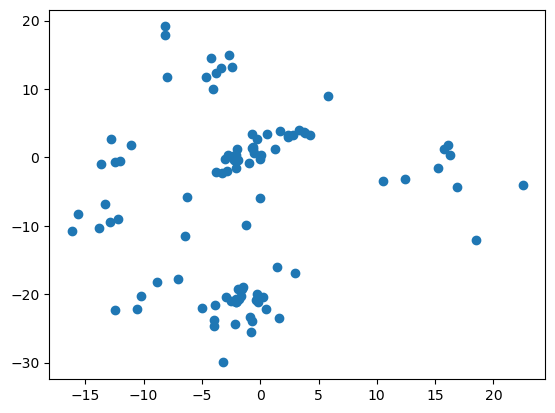

In [55]:
# Generate the samples from the Gaussion-Gaussion distribution
samples = np.zeros((n_samples, num_of_gaussian_dim)) # initialize the data matrix
z_params = np.zeros(n_samples, dtype=int) # initilize the z parameter

for i in range(n_samples):
    z_params[i] = np_rand.choice(k, p=theta_params) # assign a cluster to each sample point
    samples[i] = np_rand.multivariate_normal(eta_params[z_params[i]], cov) # draw a Sample point from the assigned cluster

# print("Samples: \n", samples)
plt.scatter(samples[:,0],samples[:,1])

In [56]:
import itertools

import matplotlib as mpl
from scipy import linalg

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # covar = np.diag(covar)
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    # plt.xlim(-20.0, 20.0)
    # plt.ylim(-20.0, 20.0)
    # plt.xticks(())
    # plt.yticks(())
    plt.title(title)

In [57]:
# The scipy BGM do not provide a variance-fixed gaussian component option. 
bgm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=None, n_init=1, covariance_type="full", max_iter=1000, verbose=2)
bgm.fit(samples)

Initialization 0
  Iteration 10	 time lapse 0.03400s	 ll change 0.00356
Initialization converged: True	 time lapse 0.03499s	 ll -653.89159


BayesianGaussianMixture(max_iter=1000, n_components=20, verbose=2)

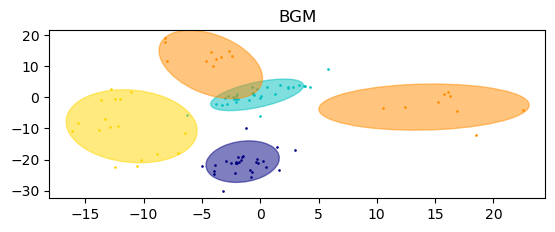

In [58]:
plot_results(samples, bgm.predict(samples), bgm.means_, bgm.covariances_, 0, "BGM")

In [ ]:
cov_samples = np.cov(samples.T)
mu_samples = np.mean(samples, axis=0)
myDp = DpGaussian(samples, alpha=1e0, Lmbda=cov_samples, mu0=mu_samples, Lmbda0=cov_samples, K=20)

for i in range(10):
    myDp.update()

mu_out, cov_out = myDp.get_mean_and_cov()
# plot_results(samples, )